# Get Dataset

In [1]:
!pip install -U --no-cache-dir gdown --pre
!gdown 1jCFc3dWPflO7HvVcvGoCQWnVrammEQOd
!unzip "/content/spam-dataset.zip"

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
Downloading...
From: https://drive.google.com/uc?id=1jCFc3dWPflO7HvVcvGoCQWnVrammEQOd
To: /content/spam-dataset.zip
100% 1.05M/1.05M [00:00<00:00, 103MB/s]
Archive:  /content/spam-dataset.zip
   creating: spam-dataset/
  inflating: __MACOSX/._spam-dataset  
  inflating: spam-dataset/test.csv   
  inflating: __MACOSX/spam-dataset/._test.csv  
  inflating: spam-dataset/train.csv  
  inflating: __MACOSX/spam-dataset/._train.csv  


# Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load and Preprocess Dataset

In [3]:
df_train = pd.read_csv('/content/spam-dataset/train.csv', header=None)
df_train.columns = ['msg', 'spam']
df_test = pd.read_csv('/content/spam-dataset/test.csv', header=None)
df_test.columns = ['msg', 'spam']

# Preprocess the data
df_train['msg'] = df_train['msg'].apply(lambda x: x.lower())
df_test['msg'] = df_test['msg'].apply(lambda x: x.lower())

# Concatenate train and test sets
df = pd.concat([df_test, df_train], ignore_index=True)

In [4]:
# Split the dataset into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(df['msg'], df['spam'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [5]:
# Encode the text data
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train).toarray()
X_val_vectorized = vectorizer.transform(X_val).toarray()
X_test_vectorized = vectorizer.transform(X_test).toarray()

In [6]:
# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [7]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_vectorized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_vectorized, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_vectorized, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.float32)

# Define Neural Network Model

In [8]:
class SpamClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SpamClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Initialize the model, loss function, and optimizer

In [9]:
input_size = X_train_tensor.shape[1]
output_size = 1  # Binary classification (spam or not spam)
hidden_size = 64
model = SpamClassifier(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model Training

In [10]:
num_epochs = 5
batch_size = 32
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    for i in range(0, X_train_tensor.shape[0], batch_size):
        inputs = X_train_tensor[i:i+batch_size]
        targets = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()

    # Validate the model
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor.view(-1, 1))
        val_preds = (val_outputs > 0.5).float()
        val_accuracy = accuracy_score(y_val_tensor.numpy(), val_preds.numpy())

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/5], Loss: 0.1233, Val Loss: 0.1132, Val Accuracy: 0.9783
Epoch [2/5], Loss: 0.0287, Val Loss: 0.0785, Val Accuracy: 0.9831
Epoch [3/5], Loss: 0.0112, Val Loss: 0.0825, Val Accuracy: 0.9807
Epoch [4/5], Loss: 0.0058, Val Loss: 0.2935, Val Accuracy: 0.9807
Epoch [5/5], Loss: 0.0036, Val Loss: 0.2995, Val Accuracy: 0.9807


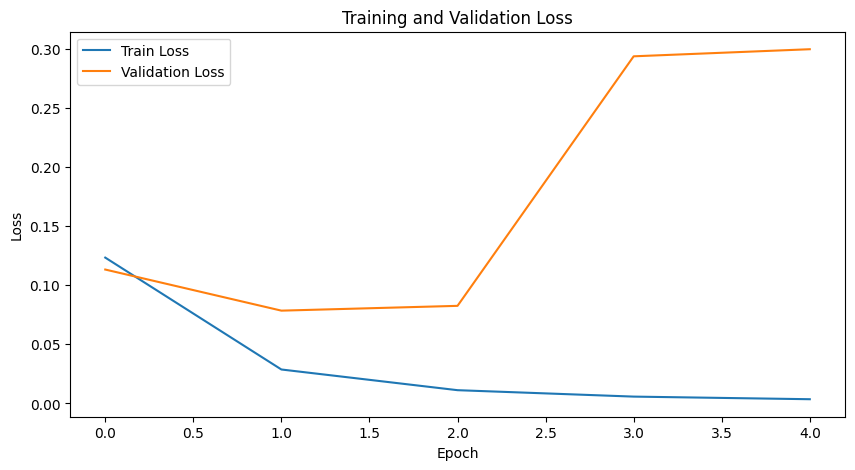

In [11]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

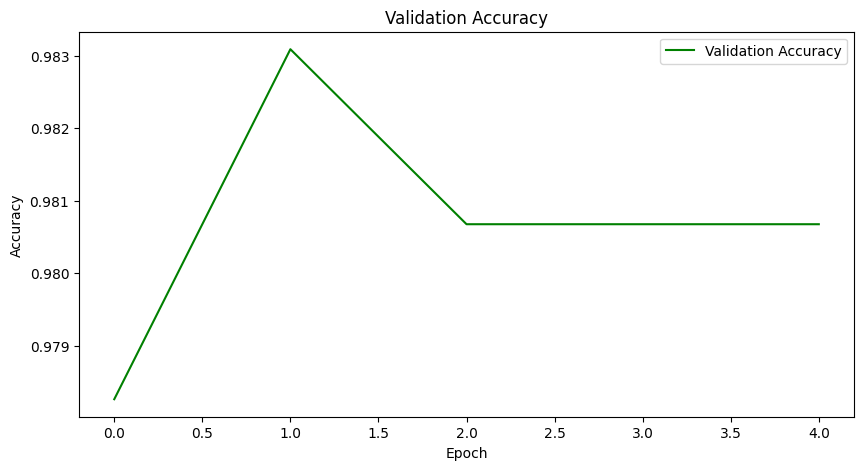

In [12]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# Model Evaluation

In [13]:
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_preds = (test_outputs > 0.5).float()
    test_accuracy = accuracy_score(y_test_tensor.numpy(), test_preds.numpy())
    test_precision = precision_score(y_test_tensor.numpy(), test_preds.numpy())
    test_recall = recall_score(y_test_tensor.numpy(), test_preds.numpy())
    test_f1 = f1_score(y_test_tensor.numpy(), test_preds.numpy())
    test_confusion_matrix = confusion_matrix(y_test_tensor.numpy(), test_preds.numpy())

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)

Test Accuracy: 0.9836
Test Precision: 0.9578
Test Recall: 0.9866
Test F1 Score: 0.9720
Test Confusion Matrix:
[[723  13]
 [  4 295]]
